## Visualize Training Run 4

In [1]:
seed=1
frac_train=0.25 
weight_decay = 1.0 #@param
freq_penalty_weight = 1e-3 
run_name='grok_1764706121'

In [2]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm.notebook as tqdm

import random
import time

# from google.colab import drive
from pathlib import Path
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "colab"
import plotly.graph_objects as go

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc

# import comet_ml
import itertools

## Support Functions

In [3]:
# A helper class to get access to intermediate activations (inspired by Garcon)
# It's a dummy module that is the identity function by default
# I can wrap any intermediate activation in a HookPoint and get a convenient 
# way to add PyTorch hooks
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []
    
    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name
    
    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output, 
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")
    
    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")
    
    def forward(self, x):
        return x

In [4]:
# Define network architecture
# I defined my own transformer from scratch so I'd fully understand each component 
# - I expect this wasn't necessary or particularly important, and a bunch of this 
# replicates existing PyTorch functionality

# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))
    
    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))
    
    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))
    
    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon
    
    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']
        
    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = self.hook_post(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()
    
    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)
    
    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache
    
    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')
    
    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

In [5]:
# Helper functions
def cuda_memory():
    print(torch.cuda.memory_allocated()/1e9)

def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly 
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes 
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss

def full_loss(model, data):
    # Take the final position only
    logits = model(data)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in data]).to('cuda')
    return cross_entropy_high_precision(logits, labels)

def test_logits(logits, bias_correction=False, original_logits=None, mode='all'):
    # Calculates cross entropy loss of logits representing a batch of all p^2 
    # possible inputs
    # Batch dimension is assumed to be first
    if logits.shape[1]==p*p:
        logits = logits.T
    if logits.shape==torch.Size([p*p, p+1]):
        logits = logits[:, :-1]
    logits = logits.reshape(p*p, p)
    if bias_correction:
        # Applies bias correction - we correct for any missing bias terms, 
        # independent of the input, by centering the new logits along the batch 
        # dimension, and then adding the average original logits across all inputs
        logits = einops.reduce(original_logits - logits, 'batch ... -> ...', 'mean') + logits
    if mode=='train':
        return cross_entropy_high_precision(logits[is_train], labels[is_train])
    elif mode=='test':
        return cross_entropy_high_precision(logits[is_test], labels[is_test])
    elif mode=='all':
        return cross_entropy_high_precision(logits, labels)

def unflatten_first(tensor):
    if tensor.shape[0]==p*p:
        return einops.rearrange(tensor, '(x y) ... -> x y ...', x=p, y=p)
    else: 
        return tensor
def cos(x, y):
    return (x.dot(y))/x.norm()/y.norm()
def mod_div(a, b):
    return (a*pow(b, p-2, p))%p
def normalize(tensor, axis=0):
    return tensor/(tensor).pow(2).sum(keepdim=True, axis=axis).sqrt()
def extract_freq_2d(tensor, freq):
    # Takes in a pxpx... or batch x ... tensor, returns a 3x3x... tensor of the 
    # Linear and quadratic terms of frequency freq
    tensor = unflatten_first(tensor)
    # Extracts the linear and quadratic terms corresponding to frequency freq
    index_1d = [0, 2*freq-1, 2*freq]
    # Some dumb manipulation to use fancy array indexing rules
    # Gets the rows and columns in index_1d
    return tensor[[[i]*3 for i in index_1d], [index_1d]*3]
def get_cov(tensor, norm=True):
    # Calculate covariance matrix
    if norm:
        tensor = normalize(tensor, axis=1)
    return tensor @ tensor.T
def is_close(a, b):
    return ((a-b).pow(2).sum()/(a.pow(2).sum().sqrt())/(b.pow(2).sum().sqrt())).item()

In [6]:
def compute_frequency_components(m):
    """
    Compute canonical frequency components of a real 2D signal m using fft2.

    Returns:
        components: list of dicts with keys:
            - 'kx': frequency index in x (rows)
            - 'ky': frequency index in y (cols)
            - 'coeff': complex FFT coefficient at (kx, ky)
        Nx, Ny: dimensions of the input
    """
    m = np.asarray(m)
    Nx, Ny = m.shape
    F = np.fft.fft2(m)

    components = []
    seen = set()

    for kx in range(Nx):
        for ky in range(Ny):
            # Conjugate partner indices for real-valued input
            kx_conj = (-kx) % Nx
            ky_conj = (-ky) % Ny

            pair = tuple(sorted([(kx, ky), (kx_conj, ky_conj)]))
            if pair in seen:
                continue
            seen.add(pair)

            # Always store the "smaller" one in lexicographic order
            kx_rep, ky_rep = pair[0]
            coeff = F[kx_rep, ky_rep]
            components.append({
                "kx": kx_rep,
                "ky": ky_rep,
                "coeff": coeff
            })

    return components, Nx, Ny


def components_to_terms(components, Nx, Ny, num_freqs, include_dc=True):
    """
    Convert FFT components into real cosine terms with amplitude & phase.

    Args:
        components: output from compute_frequency_components
        Nx, Ny: grid size
        num_freqs: number of *non-DC* frequencies to keep
        include_dc: whether to include the constant (DC) term

    Returns:
        terms: list of dicts with keys:
            - 'kx', 'ky'
            - 'amplitude'  (real, >= 0)
            - 'phase'      (in radians)
            - 'is_dc'      (bool, True only for the constant term)
    """
    terms = []
    dc_term = None

    for c in components:
        kx = c["kx"]
        ky = c["ky"]
        coeff = c["coeff"]

        # DC component (constant offset)
        if kx == 0 and ky == 0:
            dc_value = coeff.real / (Nx * Ny)
            dc_term = {
                "kx": 0,
                "ky": 0,
                "amplitude": dc_value,  # directly the constant offset
                "phase": 0.0,
                "is_dc": True,
            }
        else:
            # For real signals, combine (k, l) and (-k, -l) into:
            #   2*|F|/(Nx*Ny) * cos(2π(kx i/Nx + ky j/Ny) + phase)
            amp = 2.0 * np.abs(coeff) / (Nx * Ny)
            phase = np.angle(coeff)
            terms.append({
                "kx": kx,
                "ky": ky,
                "amplitude": amp,
                "phase": phase,
                "is_dc": False,
            })

    # Sort non-DC terms by amplitude (largest first)
    terms.sort(key=lambda t: t["amplitude"], reverse=True)

    # Keep only the top num_freqs
    terms = terms[:num_freqs]

    # Optionally prepend DC term
    if include_dc and dc_term is not None:
        terms = [dc_term] + terms

    return terms

def generate_python_reconstructor(terms, Nx, Ny, func_name="recon_func", decimals=4):
    """
    Generate a Python function as a string that reconstructs the signal
    using explicit 1D and product-of-cosine terms from a sparse Fourier representation.

    Types of terms:
      - DC term (constant)
      - Row-only:   A * cos(2π * (kx*i/Nx) + φ)
      - Col-only:   B * cos(2π * (ky*j/Ny) + φ)
      - Product:    C * cos(2π * (kx*i/Nx) + φ) * cos(2π * (ky*j/Ny) + φ)

    You must have `import numpy as np` in the scope where you paste/run this.
    """
    lines = []
    lines.append(f"def {func_name}(i, j):")

    if not terms:
        lines.append("    return 0.0")
        return "\n".join(lines)

    # Separate DC from others
    dc_terms = [t for t in terms if t.get("is_dc", False)]
    non_dc_terms = [t for t in terms if not t.get("is_dc", False)]

    if dc_terms:
        dc_val = round(dc_terms[0]["amplitude"], decimals)
        lines.append(f"    val = {dc_val}")
    else:
        lines.append("    val = 0.0")

    for t in non_dc_terms:
        kx, ky = t["kx"], t["ky"]
        A = round(t["amplitude"], decimals)
        phi = round(t["phase"], decimals)

        if A == 0:
            continue

        if kx != 0 and ky == 0:
            # Row-only cosine
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({kx}*i)/{Nx}) + {phi})"
            )
        elif kx == 0 and ky != 0:
            # Column-only cosine
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({ky}*j)/{Ny}) + {phi})"
            )
        else:
            # Product-of-cosines term (your desired "third" type)
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({kx}*i)/{Nx}) + {phi})"
                f" * np.cos(2*np.pi*(({ky}*j)/{Ny}) + {phi})"
            )

        lines.append(line)

    lines.append("    return val")

    return "\n".join(lines)

In [7]:
def set_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # For all CUDA devices
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False # Set to False for determinism

In [8]:
def embedding_frequency_penalty(model: Transformer) -> torch.Tensor:
    """
    Encourage neighboring tokens in the embedding space to be similar.
    This is a graph-Laplacian-style smoothness penalty on W_E, which
    corresponds to penalizing high-frequency Fourier modes on Z_p.

    W_E has shape [d_model, d_vocab].
    We smooth along the vocab dimension (the modular arithmetic axis).
    """
    E = model.embed.W_E  # [d_model, d_vocab]

    # Differences between consecutive tokens (0-1, 1-2, ..., (V-2)-(V-1))
    diff = E[:, 1:] - E[:, :-1]  # [d_model, d_vocab-1]

    # Wrap-around difference to respect modular structure: token V-1 vs 0
    wrap = E[:, :1] - E[:, -1:]  # [d_model, 1]

    # Mean squared differences (Laplacian smoothness)
    penalty = (diff.pow(2).mean() + wrap.pow(2).mean())
    return penalty


## Hyperparameters

In [9]:
root = Path('/home/stephen/grokking')

p=113
# seed=2 ##Set at top

lr=1e-3 #@param
p=113 #@param
d_model = 128 #@param
fn_name = 'add' #@param ['add', 'subtract', 'x2xyy2','rand']
num_epochs = 12000 #@param
save_models = True #@param
save_every = 100 # Maybe crank this down
# Stop training when test loss is <stopping_thresh
stopping_thresh = -1 #@param

num_layers = 1
batch_style = 'full'
d_vocab = p+1
n_ctx = 3
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
# batch_size = 512
use_ln = False
random_answers = np.random.randint(low=0, high=p, size=(p, p))
fns_dict = {'add': lambda x,y:(x+y)%p, 'subtract': lambda x,y:(x-y)%p, 'x2xyy2':lambda x,y:(x**2+x*y+y**2)%p, 'rand':lambda x,y:random_answers[x][y]}
fn = fns_dict[fn_name]

In [10]:
frac_train, seed

(0.25, 1)

In [11]:
def gen_train_test(frac_train, num, seed=0):
    # Generate train and test split
    pairs = [(i, j, num) for i in range(num) for j in range(num)]
    random.seed(seed)
    random.shuffle(pairs)
    div = int(frac_train*len(pairs))
    return pairs[:div], pairs[div:]

train, test = gen_train_test(frac_train, p, seed)
print(len(train), len(test))

3192 9577


In [12]:
# Creates an array of Boolean indices according to whether each data point is in 
# train or test
# Used to index into the big batch of all possible data
is_train = []
is_test = []
for x in range(p):
    for y in range(p):
        if (x, y, 113) in train:
            is_train.append(True)
            is_test.append(False)
        else:
            is_train.append(False)
            is_test.append(True)
is_train = np.array(is_train)
is_test = np.array(is_test)

## Load Final Model

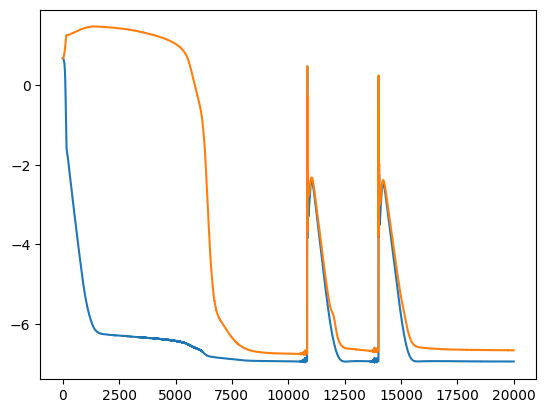

In [13]:
set_seed(seed)
model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln)
model.to('cuda');

save_dict=torch.load(root/run_name/'final.pth')
model.load_state_dict(save_dict['model'])

plt.plot(np.log10(save_dict['train_losses'])); plt.plot(np.log10(save_dict['test_losses']))

## Save Small Activation and Full Cache

In [14]:
# Do we get the same nice patters at iteration 10000?
# Ok yeah we do, let me officially call this "model end" then. 
save_dict_2=torch.load(root/run_name/(str(10000)+'.pth'))
model.load_state_dict(save_dict_2['model'])
model.eval();

In [15]:
all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
cache = {}
model.remove_all_hooks()
model.cache_all(cache)
# Final position only
original_logits = model(all_data)[:, -1]
# Remove equals sign from output logits
original_logits = original_logits[:, :-1]
original_loss = cross_entropy_high_precision(original_logits, labels)
print(f"Original loss: {original_loss.item()}")

Original loss: 1.6230427838769497e-07


In [16]:
cache['x']=all_data
cache['y']=labels

cache['logits']=original_logits
cache['probs']=torch.nn.Softmax(1)(original_logits)

cache_numpy={}
cache_sample_1={}
cache_reshaped={}
for k in cache.keys():
    cache_numpy[k]=cache[k].detach().cpu().numpy()
    cache_sample_1[k]=cache[k][:5*p].detach().cpu().numpy()
    cache_reshaped[k]=einops.rearrange(cache[k], "(x y) ... -> x y ...", x=p).detach().cpu().numpy()

In [17]:
for k in cache_sample_1.keys():
    print(k, cache_sample_1[k].shape)

blocks.0.hook_resid_pre (565, 3, 128)
blocks.0.attn.hook_k (565, 4, 3, 32)
blocks.0.attn.hook_q (565, 4, 3, 32)
blocks.0.attn.hook_v (565, 4, 3, 32)
blocks.0.attn.hook_attn_pre (565, 4, 3, 3)
blocks.0.attn.hook_attn (565, 4, 3, 3)
blocks.0.attn.hook_z (565, 4, 3, 32)
blocks.0.hook_attn_out (565, 3, 128)
blocks.0.hook_resid_mid (565, 3, 128)
blocks.0.mlp.hook_pre (565, 3, 512)
blocks.0.mlp.hook_post (565, 3, 512)
blocks.0.hook_mlp_out (565, 3, 128)
blocks.0.hook_resid_post (565, 3, 128)
x (565, 3)
y (565,)
logits (565, 113)
probs (565, 113)


In [18]:
with open(root/run_name/'final_model_activations.p', 'wb') as f: #Lol this is 300MB and real slow to load 
    pickle.dump(cache_numpy, f)

with open(root/run_name/'final_model_activations_sample.p', 'wb') as f: #Lol this is 300MB and real slow to load 
    pickle.dump(cache_sample_1, f)

with open(root/run_name/'cache_reshaped.p', 'wb') as f: #Lol this is 300MB and real slow to load 
    pickle.dump(cache_reshaped, f)

In [19]:
cache['x']

tensor([[  0,   0, 113],
        [  0,   1, 113],
        [  0,   2, 113],
        ...,
        [112, 110, 113],
        [112, 111, 113],
        [112, 112, 113]], device='cuda:0')

## P27

- Debating when I "stop training" -> leaning towrds iteration 10,000 now, but let's see if structures look good. 

In [20]:
CHILL_BROWN='#948979'
YELLOW='#ffd35a'
YELLOW_FADE='#7f6a2d'
BLUE='#65c8d0'
GREEN='#6e9671' 
CHILL_GREEN='#6c946f'
CHILL_BLUE='#3d5c6f'
FRESH_TAN='#dfd0b9'
CYAN='#00FFFF'

<Figure size 640x480 with 0 Axes>

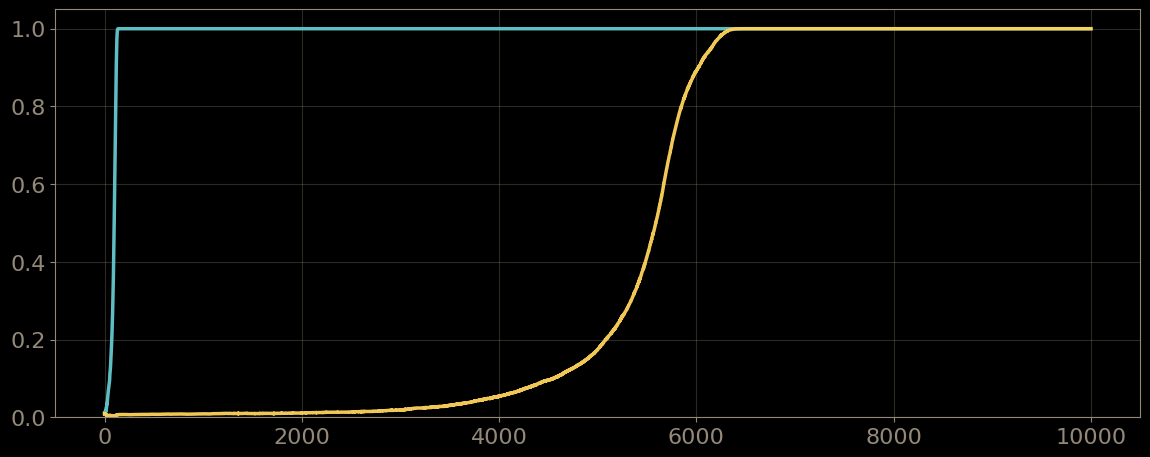

In [21]:
plt.clf()        
fig=plt.figure(0,(14,6), facecolor='k') 
ax=fig.add_subplot(111, facecolor='k')

plt.plot(save_dict['train_accs'][:10000], c=BLUE, linewidth=2.5, alpha=0.95) #'#dfd0b9')
plt.plot(save_dict['test_accs'][:10000], c=YELLOW, linewidth=2.5, alpha=0.95) #'#dfd0b9')
plt.tick_params(axis='x', colors='#948979', labelsize=16)  # Add labelsize here
plt.tick_params(axis='y', colors='#948979', labelsize=16)  # Add labelsize here

plt.gca().spines['top'].set_color('#948979')
plt.gca().spines['bottom'].set_color('#948979')
plt.gca().spines['left'].set_color('#948979')
plt.gca().spines['right'].set_color('#948979')
plt.subplots_adjust(bottom=0.2)  # Add fixed bottom margin
# plt.xlim([-10, len(to_plot)+10])
plt.ylim([0,1.05]) #Bad idea to fix or is it fine?
plt.grid(True, color='#948979', alpha=0.3)

In [22]:
# os.mkdir(root/run_name/'accuracy_curves_p18')

In [23]:
len(save_dict['train_accs'])

20000

In [24]:
# xs=np.concatenate((np.arange(1000), np.arange(1000, 20000, 10)))

In [25]:
# # for i in tqdm.tqdm(range(0, 20000, 10)): #15010, 10):
# for i in tqdm.tqdm(range(len(xs))):
#     plt.clf()        
#     fig=plt.figure(0,(14,6), facecolor='k') 
#     ax=fig.add_subplot(111, facecolor='k')
    
#     train_acc_sample=[save_dict['train_accs'][i] for i in xs[:i]]
#     test_acc_sample=[save_dict['test_accs'][i] for i in xs[:i]]
    
#     plt.plot(xs[:i], train_acc_sample, c=BLUE, linewidth=2.5, alpha=0.95) #'#dfd0b9')
#     plt.plot(xs[:i], test_acc_sample, c=YELLOW, linewidth=2.5, alpha=0.95) #'#dfd0b9')
#     plt.tick_params(axis='x', colors='#948979', labelsize=16)  # Add labelsize here
#     plt.tick_params(axis='y', colors='#948979', labelsize=16)  # Add labelsize here
    
#     plt.gca().spines['top'].set_color('#948979')
#     plt.gca().spines['bottom'].set_color('#948979')
#     plt.gca().spines['left'].set_color('#948979')
#     plt.gca().spines['right'].set_color('#948979')
#     plt.subplots_adjust(bottom=0.2)  # Add fixed bottom margin
#     # # plt.xlim([-10, len(to_plot)+10])
#     plt.ylim([0,1.05]) #Bad idea to fix or is it fine?
#     plt.grid(True, color='#948979', alpha=0.3)
#     plt.savefig(str(root/run_name/'accuracy_curves_p18')+'/'+str(i).zfill(4)+'.png', dpi=300, transparent=True) 
        

In [26]:
# os.mkdir(root/run_name/'accuracy_curves_p27')

In [27]:
# # for i in tqdm.tqdm(range(0, 20000, 10)): #15010, 10):
# for i in tqdm.tqdm(range(len(xs))):
#     plt.clf()        
#     fig=plt.figure(0,(14,3), facecolor='k') 
#     ax=fig.add_subplot(111, facecolor='k')
    
#     train_acc_sample=[save_dict['train_accs'][i] for i in xs[:i]]
#     test_acc_sample=[save_dict['test_accs'][i] for i in xs[:i]]
    
#     plt.plot(xs[:i], train_acc_sample, c=BLUE, linewidth=2.5, alpha=0.95) #'#dfd0b9')
#     plt.plot(xs[:i], test_acc_sample, c=YELLOW, linewidth=2.5, alpha=0.95) #'#dfd0b9')
#     plt.tick_params(axis='x', colors='#948979', labelsize=16)  # Add labelsize here
#     plt.tick_params(axis='y', colors='#948979', labelsize=16)  # Add labelsize here
    
#     plt.gca().spines['top'].set_color('#948979')
#     plt.gca().spines['bottom'].set_color('#948979')
#     plt.gca().spines['left'].set_color('#948979')
#     plt.gca().spines['right'].set_color('#948979')
#     plt.subplots_adjust(bottom=0.2)  # Add fixed bottom margin
#     # # plt.xlim([-10, len(to_plot)+10])
#     plt.ylim([0,1.05]) #Bad idea to fix or is it fine?
#     plt.grid(True, color='#948979', alpha=0.3)
#     plt.savefig(str(root/run_name/'accuracy_curves_p27')+'/'+str(i).zfill(4)+'.png', dpi=300, transparent=True) 
        

In [28]:
# os.mkdir(root/run_name/'accuracy_curves_linear_time_1')

In [29]:
# # for i in tqdm.tqdm(range(0, 20000, 10)): #15010, 10):
# xs_uniform=np.arange(0, 10000, 10)
# for i in tqdm.tqdm(range(len(xs_uniform))):
#     plt.clf()        
#     fig=plt.figure(0,(14,3), facecolor='k') 
#     ax=fig.add_subplot(111, facecolor='k')
    
#     plt.plot(np.arange(xs_uniform[i]), save_dict['train_accs'][:xs_uniform[i]], c=BLUE, linewidth=2.5, alpha=0.95) #'#dfd0b9')
#     plt.plot(np.arange(xs_uniform[i]), save_dict['test_accs'][:xs_uniform[i]], c=YELLOW, linewidth=2.5, alpha=0.95) #'#dfd0b9')
#     plt.tick_params(axis='x', colors='#948979', labelsize=16)  # Add labelsize here
#     plt.tick_params(axis='y', colors='#948979', labelsize=16)  # Add labelsize here
    
#     plt.gca().spines['top'].set_color('#948979')
#     plt.gca().spines['bottom'].set_color('#948979')
#     plt.gca().spines['left'].set_color('#948979')
#     plt.gca().spines['right'].set_color('#948979')
#     plt.subplots_adjust(bottom=0.2)  # Add fixed bottom margin
#     # # plt.xlim([-10, len(to_plot)+10])
#     plt.ylim([0,1.05]) #Bad idea to fix or is it fine?
#     plt.grid(True, color='#948979', alpha=0.3)
#     plt.savefig(str(root/run_name/'accuracy_curves_linear_time_1')+'/'+str(i).zfill(4)+'.png', dpi=300, transparent=True) 
        

## p28-> 30

In [30]:
all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
cache = {}
model.remove_all_hooks()
model.cache_all(cache)
# Final position only
original_logits = model(all_data)[:, -1]
# Remove equals sign from output logits
original_logits = original_logits[:, :-1]
original_loss = cross_entropy_high_precision(original_logits, labels)
print(f"Original loss: {original_loss.item()}")

Original loss: 1.6230427838769497e-07


In [31]:
for k in cache.keys():
    print(k, cache[k].shape)

blocks.0.hook_resid_pre torch.Size([12769, 3, 128])
blocks.0.attn.hook_k torch.Size([12769, 4, 3, 32])
blocks.0.attn.hook_q torch.Size([12769, 4, 3, 32])
blocks.0.attn.hook_v torch.Size([12769, 4, 3, 32])
blocks.0.attn.hook_attn_pre torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_attn torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([12769, 4, 3, 32])
blocks.0.hook_attn_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_mid torch.Size([12769, 3, 128])
blocks.0.mlp.hook_pre torch.Size([12769, 3, 512])
blocks.0.mlp.hook_post torch.Size([12769, 3, 512])
blocks.0.hook_mlp_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_post torch.Size([12769, 3, 128])


In [32]:
#Ok let's try pre -> the og. 
mr = einops.rearrange(cache['blocks.0.mlp.hook_pre'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy() 
np.save(str(root/run_name)+'/mlp_hook_pre', mr)

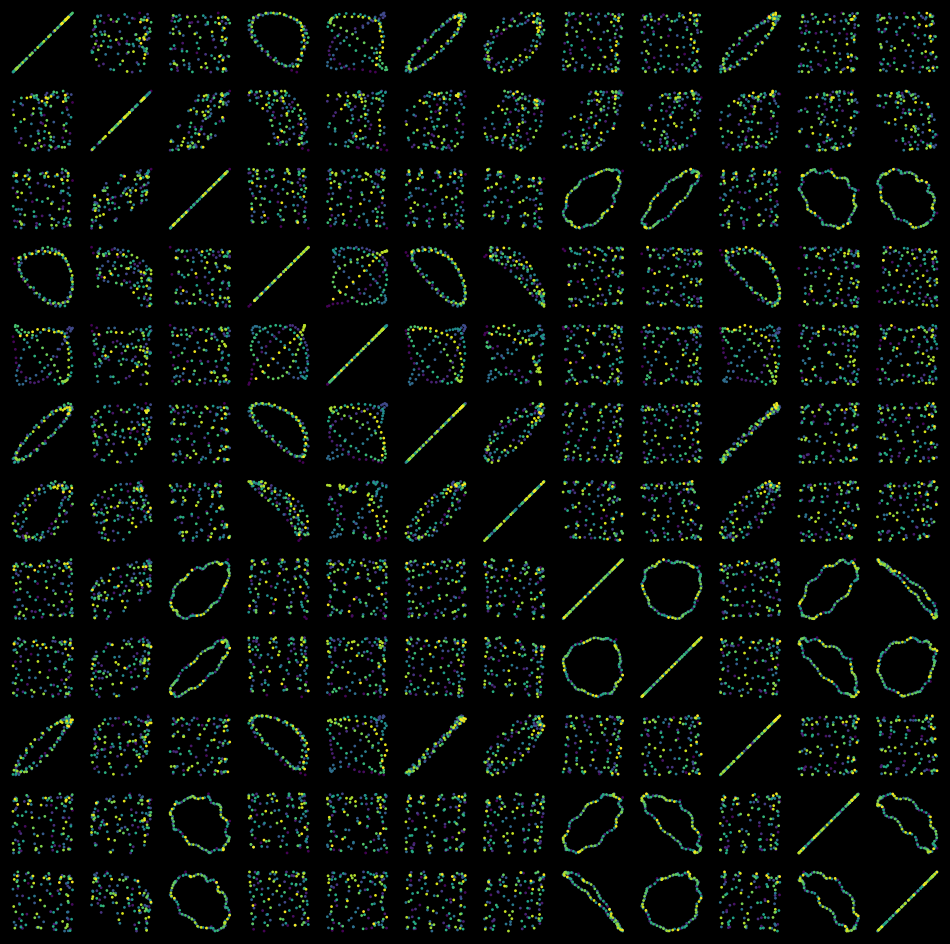

In [33]:
fig=plt.figure(0, (12,12), facecolor='k')
for i in range(12):
    for j in range(12):
        fig.add_subplot(12,12,12*i+j+1)
        plt.scatter(mr[:, 0, 2, i], mr[:, 0, 2, j], c=range(113), s=1)
        plt.axis('off')

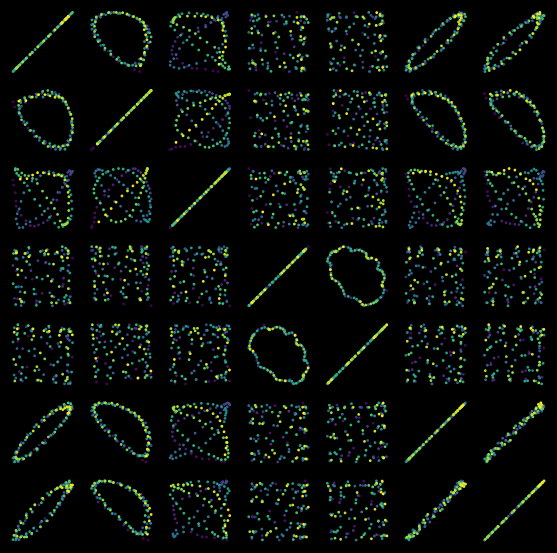

In [34]:
sample=[0, 3, 4, 2, 11, 5, 9]
fig=plt.figure(0, (12,12), facecolor='k')
for i in range(len(sample)):
    for j in range(len(sample)):
        fig.add_subplot(12,12,12*i+j+1)
        plt.scatter(mr[:, 0, 2, sample[i]], mr[:, 0, 2, sample[j]], c=range(113), s=1)
        plt.axis('off')

In [35]:
# sample=[0, 3, 4, 2, 11, 5, 9]
# fig=plt.figure(0, (12,12), facecolor='k')
# for i in range(len(sample)):
#     for j in range(len(sample)):
#         fig.add_subplot(12,12,12*i+j+1)
#         plt.scatter(mr[:, 0, 2, sample[i]], mr[:, 0, 2, sample[j]], c=range(113), s=1)
#         plt.axis('off')

One dimension at a time? 

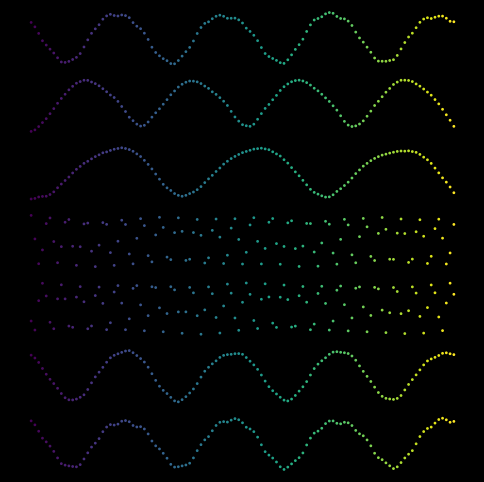

In [36]:
sample=[0, 3, 4, 2, 11, 5, 9]
fig=plt.figure(0, (6,6), facecolor='k')
for i in range(len(sample)):
    fig.add_subplot(len(sample),1,i+1)
    plt.scatter(np.arange(113), mr[:, 0, 2, sample[i]], c=range(113), s=1)
    plt.axis('off')

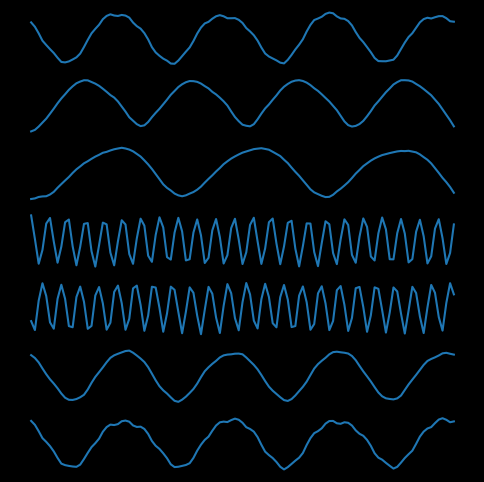

In [37]:
sample=[0, 3, 4, 2, 11, 5, 9]
fig=plt.figure(0, (6,6), facecolor='k')
for i in range(len(sample)):
    fig.add_subplot(len(sample),1,i+1)
    # plt.scatter(np.arange(113), mr[0, :, 2, sample[i]], c=range(113), s=1)
    plt.plot(cache['blocks.0.mlp.hook_pre'][:p, 2, sample[i]].detach().cpu().numpy())
    plt.axis('off')

## P31 - time history

In [38]:
# time_history_to_save=[]
# for i in tqdm.tqdm(range(0, 10000, 10)): #15010, 10):
#     save_dict_2=torch.load(root/run_name/(str(i)+'.pth'))
#     model.load_state_dict(save_dict_2['model'])
#     model.eval()

#     all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
#     cache = {}
#     model.remove_all_hooks()
#     model.cache_all(cache)
#     original_logits = model(all_data)[:, -1]

#     time_history_to_save.append(cache['blocks.0.mlp.hook_pre'][:p].detach().cpu().numpy())

In [39]:
# time_history_to_save=np.array(time_history_to_save)
# np.save(str(root/run_name/'time_history_mlp_hook_pre_1'), time_history_to_save)

In [40]:
# time_history_to_save.shape

## P33 - Fourier Transform Action

Ok so here, next to each time series plot, I want a simplified FFT plot, with a few key frequencies on the bottom, then i want phase aligned wave on top of each set of data points. 

In [41]:
os.makedirs(root/run_name/'ffts_1', exist_ok=True)

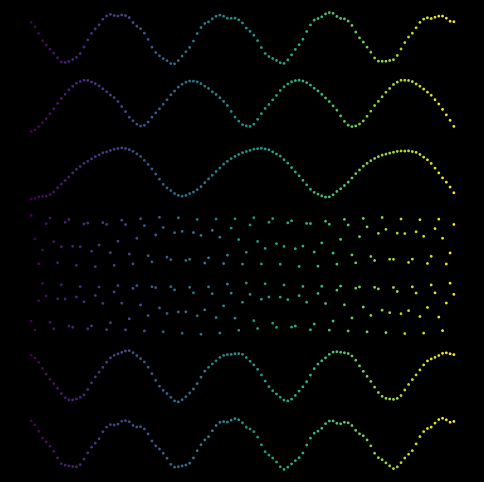

In [42]:
sample=[0, 3, 4, 2, 11, 5, 9]
fig=plt.figure(0, (6,6), facecolor='k')
for i in range(len(sample)):
    fig.add_subplot(len(sample),1,i+1)
    # plt.scatter(np.arange(113), mr[0, :, 2, sample[i]], c=range(113), s=1)
    plt.scatter(np.arange(113), cache['blocks.0.mlp.hook_pre'][:p, 2, sample[i]].detach().cpu().numpy(), c=range(113), s=1)
    plt.axis('off')

Top 5 Frequencies:
  k= 4  |Y[k]|=127.6904   omega = 2π * 4/113 = 0.22241 rad
  k= 8  |Y[k]|=15.9209   omega = 2π * 8/113 = 0.44483 rad
  k=12  |Y[k]|=7.7503   omega = 2π * 12/113 = 0.66724 rad
  k= 3  |Y[k]|=4.9550   omega = 2π * 3/113 = 0.16681 rad
  k= 6  |Y[k]|=2.2972   omega = 2π * 6/113 = 0.33362 rad


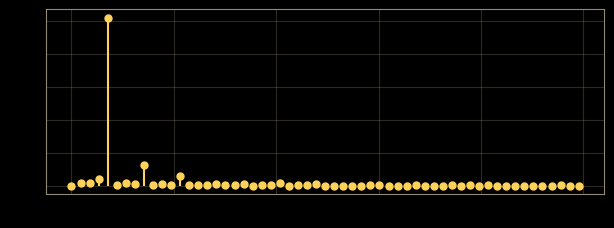

In [43]:
i=1
y=cache['blocks.0.mlp.hook_pre'][:p, 2, sample[i]].detach().cpu().numpy()

N = len(y)
x = np.arange(N)

y_centered = y - y.mean()
Y = np.fft.rfft(y_centered)            
freqs = np.fft.rfftfreq(N, d=1.0)  

k_peak = np.argmax(np.abs(Y[1:])) + 1 

A = 2 * np.abs(Y[k_peak]) / N          # amplitude of the sinusoid
phi = np.angle(Y[k_peak])              # phase
f_peak = freqs[k_peak]      

y_fit = A * np.cos(2 * np.pi * f_peak * x + phi)

N = len(y)
x = np.arange(N)

y_centered = y - y.mean()
Y = np.fft.rfft(y_centered)            
freqs = np.fft.rfftfreq(N, d=1.0)  

fig=plt.figure(0,(3*2.4,3*0.8), facecolor='k') 
ax=fig.add_subplot(111, facecolor='k')
markerline, stemlines, baseline = ax.stem(freqs, np.abs(Y))

# Set colors
markerline.set_color(YELLOW)
markerline.set_markersize(5)
stemlines.set_color(YELLOW)
# baseline.set_color(CHILL_BROWN)
baseline.set_visible(False)

plt.gca().spines['top'].set_color('#948979')
plt.gca().spines['bottom'].set_color('#948979')
plt.gca().spines['left'].set_color('#948979')
plt.gca().spines['right'].set_color('#948979')
plt.grid(True, color='#948979', alpha=0.3)
plt.savefig(str(root/run_name/'ffts_1'/('fft_'+str(i)+'.svg')), bbox_inches='tight')
np.save(str(root/run_name/'ffts_1'/('fit_'+str(i))), y_fit) #+y.mean())

magnitudes = np.abs(Y)
magnitudes[0] = 0       # zero out DC so it doesn't get picked

# Find top 5 indices
top_k = np.argsort(magnitudes)[::-1][:5]   # biggest magnitudes first

print("Top 5 Frequencies:")
for k in top_k:
    mag = magnitudes[k]
    omega = 2 * np.pi * k / N
    print(f"  k={k:2d}  |Y[k]|={mag:.4f}   omega = 2π * {k}/{N} = {omega:.5f} rad")

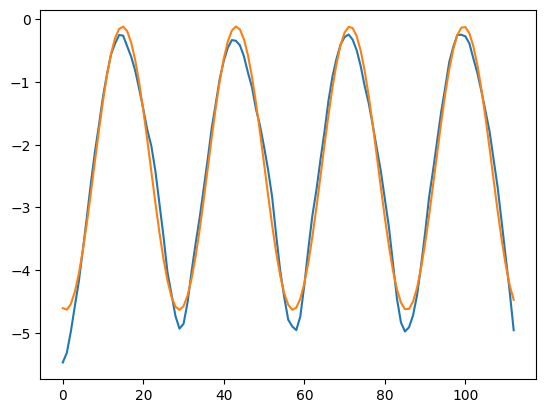

In [44]:
plt.plot(y)
plt.plot(y_fit+y.mean())

## P34 - Embedding Layer & Sparse Probes

In [45]:
from sklearn.linear_model import Lasso

def sparse_probe(X, k, alpha=0.01, func='cos'):
    """
    Train a sparse linear probe to predict cos(2πkn/p) from embeddings.
    
    Args:
        X: embedding matrix [p, d]
        k: frequency to probe for
        alpha: L1 regularization strength (higher = sparser)
    
    Returns:
        model: fitted Lasso model
        pred: predicted cosine
        target: true cosine
    """
    if func=='cos': target = np.cos(2 * np.pi * k * np.arange(p) / p)
    if func=='sin': target = np.sin(2 * np.pi * k * np.arange(p) / p)
    
    X_np = X.detach().cpu().numpy() if torch.is_tensor(X) else X
    
    sparse_model = Lasso(alpha=alpha, fit_intercept=True, max_iter=10000)
    sparse_model.fit(X_np, target)
    
    pred = sparse_model.predict(X_np)
    
    return sparse_model, pred, target

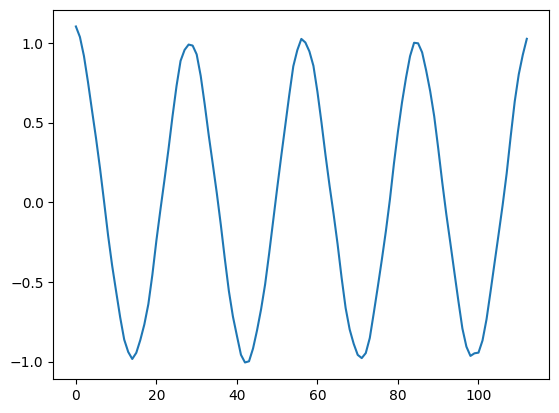

In [46]:
train_step=10000
save_dict_2=torch.load(root/run_name/(str(train_step)+'.pth'))
model.load_state_dict(save_dict_2['model'])

all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
cache = {}
model.remove_all_hooks()
model.cache_all(cache)

original_logits = model(all_data)[:, -1]
# Remove equals sign from output logits
original_logits = original_logits[:, :-1]

X=einops.rearrange(cache['blocks.0.hook_resid_pre'], "(x y) ... -> x y ...", x=p).detach().cpu()[:,0, 0, :]

# probe_W, probe_b, pred_1 = compute_probe(X, p, k=6)
# alpha=0.01
sparse_model, pred, target = sparse_probe(X, k=4, alpha=0.001, func='cos')

neuron_idx=0
plt.plot(pred)

In [47]:
# I think it's just going to be easier here to save this: 
np.save(str(root/run_name)+'/hook_resid_pre', 
        einops.rearrange(cache['blocks.0.hook_resid_pre'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy())

In [48]:
np.sum(np.abs(sparse_model.coef_) > 1e-8)
## Ok so I don't think i should be TRAINING new probes at each step -> lasso gets a little crazy and uses way to many terms. 

8

In [49]:
np.where(np.abs(sparse_model.coef_) > 1e-8)

(array([  3,  22,  70,  77,  97, 109, 110, 120]),)

In [50]:
sparse_model.coef_[np.abs(sparse_model.coef_)>1e-8]

array([-2.6663165 , -0.25714037, -0.44786936,  2.2651575 , -1.7859838 ,
       -1.0981598 ,  0.15692602, -0.7603928 ], dtype=float32)

In [51]:
sparse_model.intercept_

0.085945606

In [52]:
np.save(str(root/run_name)+'/sparse_probe_1', pred)

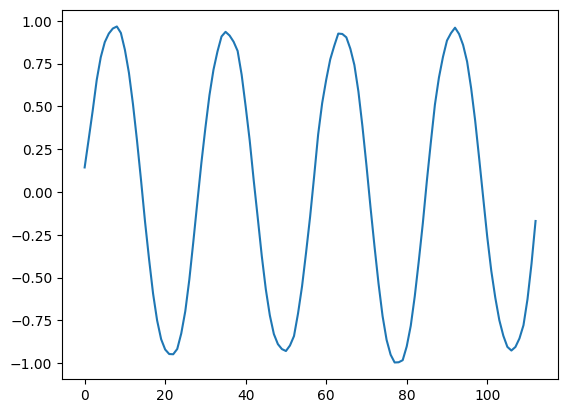

In [53]:
sparse_model, pred, target = sparse_probe(X, k=4, alpha=0.001, func='sin')
plt.plot(pred)
np.save(str(root/run_name)+'/sparse_probe_2', pred)

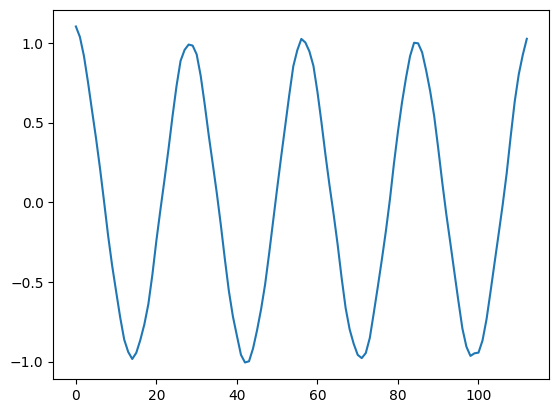

In [54]:
X=einops.rearrange(cache['blocks.0.hook_resid_pre'], "(x y) ... -> x y ...", x=p).detach().cpu()[0,:, 1, :]
sparse_model, pred, target = sparse_probe(X, k=4, alpha=0.001, func='cos')
plt.plot(pred)
np.save(str(root/run_name)+'/sparse_probe_3', pred)

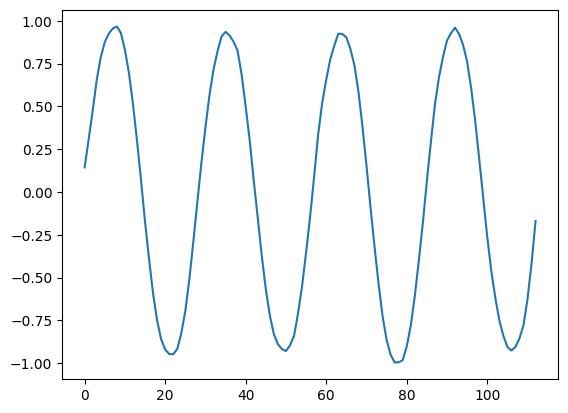

In [55]:
X=einops.rearrange(cache['blocks.0.hook_resid_pre'], "(x y) ... -> x y ...", x=p).detach().cpu()[0,:, 1, :]
sparse_model, pred, target = sparse_probe(X, k=4, alpha=0.001, func='sin')
plt.plot(pred)
np.save(str(root/run_name)+'/sparse_probe_4', pred)

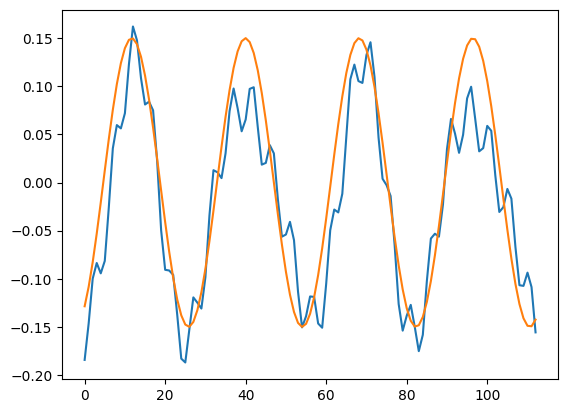

In [56]:
plt.plot(X[:, 3])
plt.plot(np.arange(0, 113), 0.15*np.cos(np.arange(0, 113)*8*np.pi/113-2.6))

## P45
- Looking for two neurons with strong cross terms, low frequencies, and bout pi/2 out of phase!
- Bonus points for being less noisy
- Oh and should be reasonable well approximated by strongest product term

In [57]:
from tqdm import tqdm

In [58]:
# ---- Helper for classifying term type ----
def classify_term_type(kx, ky, is_dc):
    if is_dc:
        return "dc"
    if kx != 0 and ky == 0:
        return "row"
    if kx == 0 and ky != 0:
        return "col"
    if kx == 0 and ky == 0:
        return "dc"
    return "cross"  # kx != 0 and ky != 0


# ---- Loop over neurons and build DataFrame ----
all_rows = []

for neuron_idx in tqdm(range(512)):
    # 113 x 113 slice for this neuron
    m_slice = mr[:, :, 2, neuron_idx]

    components, Nx, Ny = compute_frequency_components(m_slice)
    terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)

    # Max amplitude (non-DC) for this neuron, for "strong" comparison later
    non_dc_terms = [t for t in terms if not t.get("is_dc", False)]
    max_amp = max((t["amplitude"] for t in non_dc_terms), default=0.0)

    for rank, t in enumerate(terms):
        is_dc = t.get("is_dc", False)
        kx = t["kx"]
        ky = t["ky"]
        amp = t["amplitude"]
        phase = t["phase"]

        term_type = classify_term_type(kx, ky, is_dc)

        all_rows.append({
            "neuron_idx": neuron_idx,
            "term_rank": rank,          # 0 = DC if include_dc=True
            "is_dc": is_dc,
            "term_type": term_type,     # "dc", "row", "col", "cross"
            "kx": kx,
            "ky": ky,
            "amplitude": amp,
            "phase": phase,
            "max_amp_neuron": max_amp,  # per neuron
        })

df = pd.DataFrame(all_rows)
df['relative_amplitude']=df['amplitude']/df['max_amp_neuron']

100%|██████████████████████████████| 512/512 [00:15<00:00, 32.52it/s]


In [59]:
df['kx'].value_counts()

kx
0     1143
23     629
4      492
6      106
3       77
46      67
8       46
Name: count, dtype: int64

In [60]:
dff=df[df['kx']==4]
dff=dff[dff['ky']==4]

In [61]:
dff.sort_values(by='relative_amplitude', ascending=False)[50:70]

,neuron_idx,term_rank,is_dc,term_type,kx,ky,amplitude,phase,max_amp_neuron,relative_amplitude
1741,348,1,False,cross,4,4,0.149542,1.694637,0.149542,1.000000
2501,500,1,False,cross,4,4,0.192513,1.786971,0.192513,1.000000
2536,507,1,False,cross,4,4,0.219084,2.521400,0.219084,1.000000
1726,345,1,False,cross,4,4,0.146020,1.546097,0.146020,1.000000
2281,456,1,False,cross,4,4,0.200235,1.201548,0.200235,1.000000
813,162,3,False,cross,4,4,0.184907,1.740448,0.188362,0.981653
1657,331,2,False,cross,4,4,0.155411,3.039789,0.163528,0.950366
2128,425,3,False,cross,4,4,0.129672,0.032889,0.136645,0.948973
1293,258,3,False,cross,4,4,0.158737,0.392551,0.170537,0.930809
1072,214,2,False,cross,4,4,0.100016,-1.374657,0.111775,0.894798


In [62]:
# for neuron_idx in dff.sort_values(by='relative_amplitude', ascending=False)[:50]['neuron_idx']:
#     FT = np.fft.fft2(mr[:,:,2,neuron_idx])
    
#     components, Nx, Ny = compute_frequency_components(mr[:,:,2,neuron_idx])
#     terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)
#     code_str = generate_python_reconstructor(terms, Nx, Ny,
#                                              func_name="approx_M",
#                                              decimals=3)
#     print(neuron_idx, code_str)

In [63]:
neuron_idx=106
FT = np.fft.fft2(mr[:,:,2,neuron_idx])

components, Nx, Ny = compute_frequency_components(mr[:,:,2,neuron_idx])
terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)
code_str = generate_python_reconstructor(terms, Nx, Ny,
                                         func_name="approx_M",
                                         decimals=3)
print(code_str)

def approx_M(i, j):
    val = 0.939
    val += 0.354 * np.cos(2*np.pi*((4*i)/113) + -0.516) * np.cos(2*np.pi*((4*j)/113) + -0.516)
    val += 0.26 * np.cos(2*np.pi*((4*i)/113) + -0.0) * np.cos(2*np.pi*((109*j)/113) + -0.0)
    val += 0.173 * np.cos(2*np.pi*((8*i)/113) + 2.653)
    val += 0.173 * np.cos(2*np.pi*((8*j)/113) + 2.653)
    return val


In [64]:
def approx_M(i, j):
    val = 0.939
    val += 0.354 * np.cos(2*np.pi*((4*i)/113) + -0.516) * np.cos(2*np.pi*((4*j)/113) + -0.516)
    val += 0.26 * np.cos(2*np.pi*((4*i)/113) + -0.0) * np.cos(2*np.pi*((109*j)/113) + -0.0)
    val += 0.173 * np.cos(2*np.pi*((8*i)/113) + 2.653)
    val += 0.173 * np.cos(2*np.pi*((8*j)/113) + 2.653)
    return val

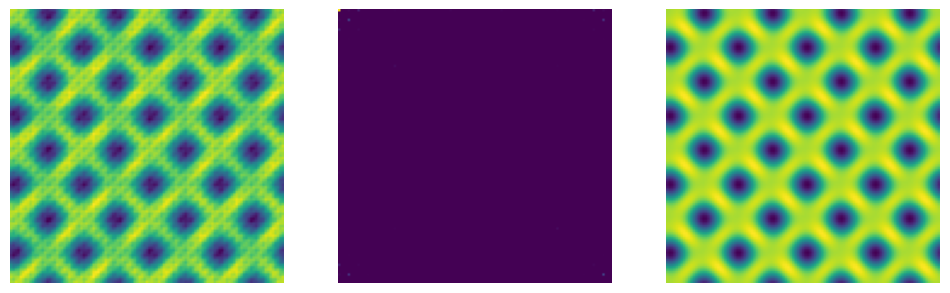

In [65]:
m_approx=np.zeros((p,p))
for i in range(p):
    for j in range(p):
        m_approx[i,j]=approx_M(i,j)

fig=plt.figure(0, (12, 6))
fig.add_subplot(1,3,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,3,2); plt.imshow(np.abs(FT));  plt.axis('off')
fig.add_subplot(1,3,3); plt.imshow(m_approx); plt.axis('off');

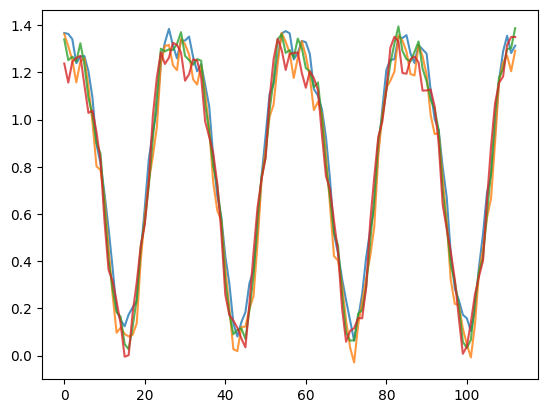

In [66]:
plt.plot(mr[:4,:,2,neuron_idx].T, alpha=0.8);

In [67]:
plt.clf()
plt.figure(frameon=False)
ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
ax.set_axis_off()
plt.gcf().add_axes(ax)
plt.imshow(np.rot90(mr[:,:,2,neuron_idx].T)) #have to transpose if transposing u and v and param_surface_1
plt.savefig(str(root/run_name)+'/activations_'+str(neuron_idx).zfill(3)+'.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.close()

<Figure size 640x480 with 0 Axes>

Ok to show decomposition, I need to export heatmaps for the components - let's do that

In [68]:
fourier_funcs = [
    lambda i, j: 0.354 * np.cos(2*np.pi*((4*i)/113) - 0.516) * np.cos(2*np.pi*((4*j)/113) - 0.516),
    # lambda i, j: 0.26 * np.cos(2*np.pi*((4*i)/113)) * np.cos(2*np.pi*((109*j)/113)),
    lambda i, j: 0.173 * np.cos(2*np.pi*((8*i)/113) + 2.653),
    lambda i, j: 0.173 * np.cos(2*np.pi*((8*j)/113) + 2.653),
]

comp_arrays = []
for fourier_comp_index in range(len(fourier_funcs)):
    arr = np.zeros((p, p))
    for i in range(p):
        for j in range(p):
            arr[i, j] = fourier_funcs[fourier_comp_index](i, j)
    comp_arrays.append(arr)

    plt.clf()
    plt.figure(frameon=False)
    ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
    ax.set_axis_off()
    plt.gcf().add_axes(ax)
    plt.imshow(np.rot90(arr)) #np.rot90(arr.T)) #have to transpose if transposing u and v and param_surface_1
    plt.savefig(str(root/run_name)+'/activations_'+str(neuron_idx).zfill(3)+'_component_'+str(fourier_comp_index)+'.png', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

<Figure size 640x480 with 0 Axes>

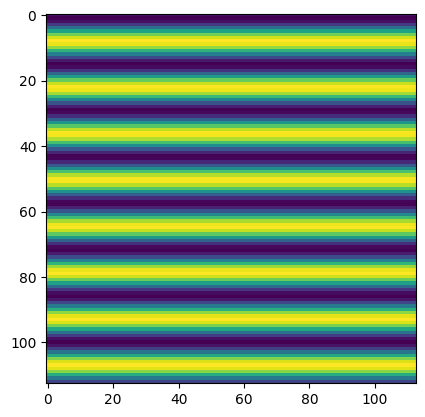

In [69]:
plt.imshow(comp_arrays[1])

In [70]:
neuron_idx=331	
FT = np.fft.fft2(mr[:,:,2,neuron_idx])

components, Nx, Ny = compute_frequency_components(mr[:,:,2,neuron_idx])
terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)
code_str = generate_python_reconstructor(terms, Nx, Ny,
                                         func_name="approx_M",
                                         decimals=3)
print(code_str)

def approx_M(i, j):
    val = 0.522
    val += 0.164 * np.cos(2*np.pi*((23*i)/113) + -1.119) * np.cos(2*np.pi*((23*j)/113) + -1.119)
    val += 0.155 * np.cos(2*np.pi*((4*i)/113) + 3.04) * np.cos(2*np.pi*((4*j)/113) + 3.04)
    val += 0.147 * np.cos(2*np.pi*((4*i)/113) + 3.142) * np.cos(2*np.pi*((109*j)/113) + 3.142)
    val += 0.131 * np.cos(2*np.pi*((23*i)/113) + -0.0) * np.cos(2*np.pi*((90*j)/113) + -0.0)
    return val


In [71]:
def approx_M(i, j):
    val = 0.792
    val += 0.304 * np.cos(2*np.pi*((4*i)/113) + 1.587) * np.cos(2*np.pi*((4*j)/113) + 1.587)
    val += 0.146 * np.cos(2*np.pi*((8*j)/113) + -1.58)
    val += 0.146 * np.cos(2*np.pi*((8*i)/113) + -1.58)
    val += 0.144 * np.cos(2*np.pi*((23*i)/113) + -1.511) * np.cos(2*np.pi*((23*j)/113) + -1.511)
    return val

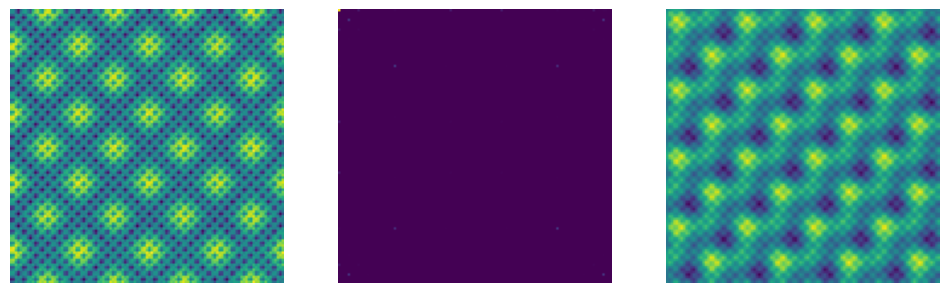

In [72]:
m_approx=np.zeros((p,p))
for i in range(p):
    for j in range(p):
        m_approx[i,j]=approx_M(i,j)

fig=plt.figure(0, (12, 6))
fig.add_subplot(1,3,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,3,2); plt.imshow(np.abs(FT));  plt.axis('off')
fig.add_subplot(1,3,3); plt.imshow(m_approx); plt.axis('off');

In [73]:
plt.clf()
plt.figure(frameon=False)
ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
ax.set_axis_off()
plt.gcf().add_axes(ax)
plt.imshow(np.rot90(mr[:,:,2,neuron_idx].T)) #have to transpose if transposing u and v and param_surface_1
plt.savefig(str(root/run_name)+'/activations_'+str(neuron_idx).zfill(3)+'.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.close()

<Figure size 640x480 with 0 Axes>

- Ok will need ot decouple training and viz at some point
- For now though, let's keep rollin.

### Fancy Trig Action

In [76]:
m_diff=np.zeros((p,p))
for i in range(p):
    for j in range(p):
        m_diff[i,j]=np.cos(2*np.pi*((4*i)/113) + -0.516) * np.cos(2*np.pi*((4*j)/113) + -0.516) - \
                    np.cos(2*np.pi*((4*i)/113) + 3.04) * np.cos(2*np.pi*((4*j)/113) + 3.04)

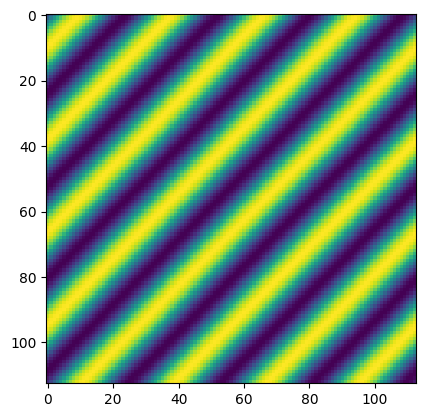

In [77]:
plt.imshow(m_diff)

- Nice, man I think that's going to be a really cool part of the animation!

In [79]:
#Somewhat different tooling for this section - could get me into a pickle
def fourier_approx_2d(x, num_freqs):
    """
    x: 2D real array, shape (Nx, Ny)
    num_freqs: number of Fourier coefficients to keep (by magnitude)

    Returns:
        F_sparse: sparse 2D Fourier spectrum (complex, same shape as x)
        x_hat: real reconstruction from the sparse spectrum
    """
    # 2D FFT
    F = np.fft.fft2(x)
    
    # Flatten and sort coefficients by magnitude (descending)
    flat = F.ravel()
    idx_sorted = np.argsort(np.abs(flat))[::-1]
    
    # Indices of top num_freqs coefficients
    keep_idx = idx_sorted[:num_freqs]
    
    # Build sparse spectrum
    flat_sparse = np.zeros_like(flat, dtype=complex)
    flat_sparse[keep_idx] = flat[keep_idx]
    F_sparse = flat_sparse.reshape(F.shape)
    
    # Reconstruct (take real part to remove tiny numerical imaginary noise)
    x_hat = np.fft.ifft2(F_sparse).real
    
    return F_sparse, x_hat

def spectrum_to_terms(F_sparse):
    """
    Turn a sparse spectrum into a list of (kx, ky, amplitude, phase) terms.
    Only nonzero entries are returned.
    """
    Nx, Ny = F_sparse.shape
    terms = []
    
    for (kx, ky), c in np.ndenumerate(F_sparse):
        if c == 0:
            continue
        amp = np.abs(c) / (Nx * Ny)   # matches np.fft normalization
        phase = np.angle(c)
        terms.append({
            "kx": kx,
            "ky": ky,
            "amplitude": amp,
            "phase": phase
        })
    
    return terms

def generate_python_reconstructor(terms, Nx, Ny, func_name="recon_func", decimals=4):
    """
    Generate a Python function as a string that reconstructs the signal
    using explicit cosine terms from a sparse Fourier representation.
    """

    lines = []
    # lines.append("import numpy as np\n")
    lines.append(f"def {func_name}(i, j):")
    
    if len(terms) == 0:
        lines.append("    return 0.0")
        return "\n".join(lines)

    lines.append("    return (")

    for t in terms:
        kx, ky = t["kx"], t["ky"]
        A = round(t["amplitude"], decimals)
        phi = round(t["phase"], decimals)

        if A == 0:
            continue

        # One cosine term
        line = (
            f"        {A} * np.cos(2*np.pi*((({kx}*i)/{Nx}) + "
            f"(({ky}*j)/{Ny})) + {phi}) +"
        )
        lines.append(line)

    # Remove trailing '+'
    lines[-1] = lines[-1].rstrip(" +")

    lines.append("    )")

    return "\n".join(lines)

# def reconstruction_error(x, x_hat, remove_mean=True):
#     if remove_mean:
#         x=x-x.mean(); x_hat=x_hat-x_hat.mean()
#     diff = x - x_hat
#     mse = np.mean(diff**2)
#     rel_l2 = np.linalg.norm(diff) / np.linalg.norm(x)
#     return mse, rel_l2

In [89]:
mr = einops.rearrange(cache['blocks.0.hook_mlp_out'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy()
mr.shape

(113, 113, 3, 128)

In [90]:
np.save(str(root/run_name)+'/hook_mlp_out', mr)

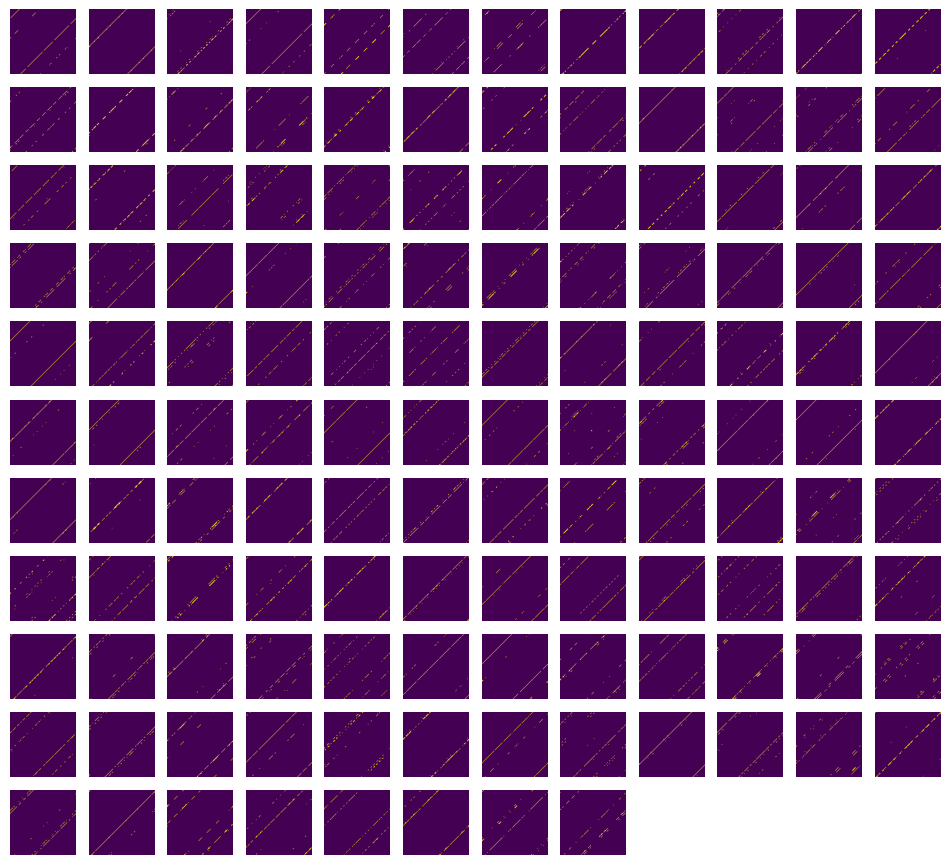

In [98]:
fig=plt.figure(0, (12,12))
for neuron_idx in range(128):
    fig.add_subplot(12, 12, neuron_idx+1)
    plt.imshow(mr[:,:,2,neuron_idx]> np.percentile(mr[:,:,2,neuron_idx].ravel(), 99))
    plt.axis('off')

In [103]:
neuron_idx=10
F_sparse, x_hat = fourier_approx_2d(mr[:,:,2,neuron_idx], num_freqs=6)

terms=spectrum_to_terms(F_sparse)
c=generate_python_reconstructor(terms, 113, 113)
print(c)

def recon_func(i, j):
    return (
        1.8793 * np.cos(2*np.pi*(((3*i)/113) + ((3*j)/113)) + 0.4171) +
        1.9406 * np.cos(2*np.pi*(((4*i)/113) + ((4*j)/113)) + 0.2689) +
        1.6699 * np.cos(2*np.pi*(((23*i)/113) + ((23*j)/113)) + 1.7947) +
        1.6699 * np.cos(2*np.pi*(((90*i)/113) + ((90*j)/113)) + -1.7947) +
        1.9406 * np.cos(2*np.pi*(((109*i)/113) + ((109*j)/113)) + -0.2689) +
        1.8793 * np.cos(2*np.pi*(((110*i)/113) + ((110*j)/113)) + -0.4171)
    )


In [107]:
def recon_func(i, j):
    return (
        1.8793 * np.cos(2*np.pi*(((3*i)/113) + ((3*j)/113)) + 0.4171) +
        1.9406 * np.cos(2*np.pi*(((4*i)/113) + ((4*j)/113)) + 0.2689) +
        1.6699 * np.cos(2*np.pi*(((23*i)/113) + ((23*j)/113)) + 1.7947) +
        1.6699 * np.cos(2*np.pi*(((90*i)/113) + ((90*j)/113)) + -1.7947) +
        1.9406 * np.cos(2*np.pi*(((109*i)/113) + ((109*j)/113)) + -0.2689) +
        1.8793 * np.cos(2*np.pi*(((110*i)/113) + ((110*j)/113)) + -0.4171)
    )

In [108]:
plt.clf()
plt.figure(frameon=False)
ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
ax.set_axis_off()
plt.gcf().add_axes(ax)
plt.imshow(np.rot90(mr[:,:,2,neuron_idx].T)) #have to transpose if transposing u and v and param_surface_1
plt.savefig(str(root/run_name)+'/activations_post_'+str(neuron_idx).zfill(3)+'.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.close()

<Figure size 640x480 with 0 Axes>

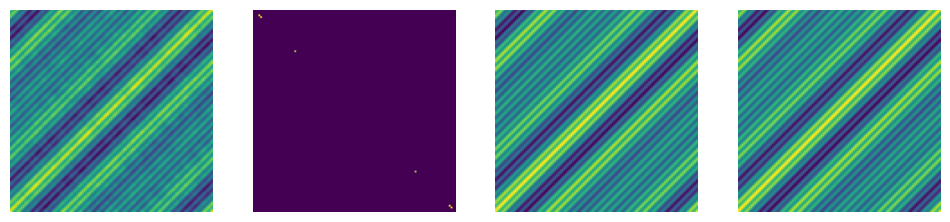

In [109]:
m_approx=np.zeros((p,p))
for i in range(p):
    for j in range(p):
        m_approx[i,j]=recon_func(i,j)

fig=plt.figure(0, (12, 6))
fig.add_subplot(1,4,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,4,2); plt.imshow(np.abs(F_sparse));  plt.axis('off')
fig.add_subplot(1,4,3); plt.imshow(x_hat); plt.axis('off');
fig.add_subplot(1,4,4); plt.imshow(m_approx); plt.axis('off');

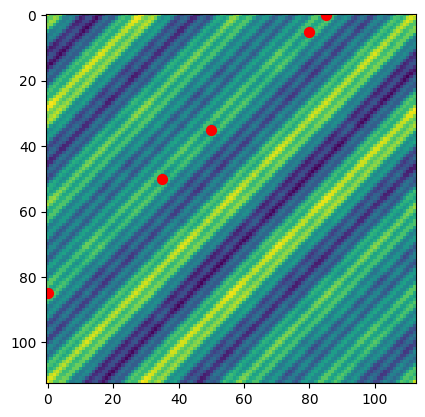

In [95]:
plt.imshow(mr[:,:,2,neuron_idx]);
plt.scatter(85, 0, c='r', s=50)
plt.scatter(80, 5, c='r', s=50)
plt.scatter(50, 35, c='r', s=50)
plt.scatter(35, 50, c='r', s=50)
plt.scatter(0, 85, c='r', s=50)

In [68]:
# plt.clf()
# plt.figure(frameon=False)
# ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
# ax.set_axis_off()
# plt.gcf().add_axes(ax)
# plt.imshow(np.rot90(mr[:,:,2].T)) #have to transpose if transposing u and v and param_surface_1
# plt.savefig(str(root/run_name)+'/logit_2.png', bbox_inches='tight', pad_inches=0, dpi=300)
# plt.close()

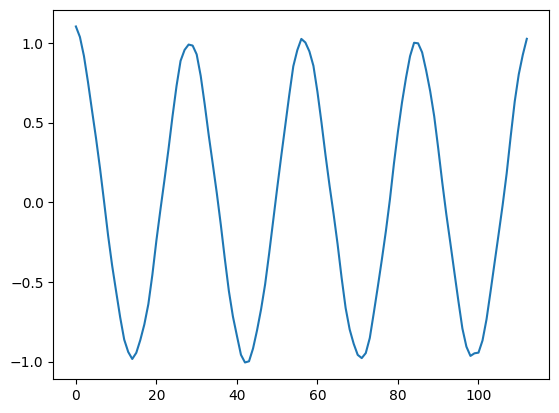

8

### Excluded Loss

In [105]:
def fft1d(tensor):
    # Converts a tensor with dimension p into the Fourier basis
    return tensor @ fourier_basis.T

def fourier_2d_basis_term(x_index, y_index):
    # Returns the 2D Fourier basis term corresponding to the outer product of 
    # the x_index th component in the x direction and y_index th component in the 
    # y direction
    # Returns a 1D vector of length p^2
    return (fourier_basis[x_index][:, None] * fourier_basis[y_index][None, :]).flatten()

def fft2d(mat):
    # Converts a pxpx... or batch x ... tensor into the 2D Fourier basis.
    # Output has the same shape as the original
    shape = mat.shape
    mat = einops.rearrange(mat, '(x y) ... -> x y (...)', x=p, y=p)
    fourier_mat = torch.einsum('xyz,fx,Fy->fFz', mat, fourier_basis, fourier_basis)
    return fourier_mat.reshape(shape)

def analyse_fourier_2d(tensor, top_k=10):
    # Processes a (p,p) or (p*p) tensor in the 2D Fourier Basis, showing the 
    # top_k terms and how large a fraction of the variance they explain
    values, indices = tensor.flatten().pow(2).sort(descending=True)
    rows = []
    total = values.sum().item()
    for i in range(top_k):
        rows.append([tensor.flatten()[indices[i]].item(),
                     values[i].item()/total, 
                     values[:i+1].sum().item()/total, 
                     fourier_basis_names[indices[i].item()//p], 
                     fourier_basis_names[indices[i]%p]])
    display(pd.DataFrame(rows, columns=['Coefficient', 'Frac explained', 'Cumulative frac explained', 'x', 'y']))

def get_2d_fourier_component(tensor, x, y):
    # Takes in a batch x ... tensor and projects it onto the 2D Fourier Component 
    # (x, y)
    vec = fourier_2d_basis_term(x, y).flatten()
    return vec[:, None] @ (vec[None, :] @ tensor)

def get_component_cos_xpy(tensor, freq, collapse_dim=False):
    # Gets the component corresponding to cos(freq*(x+y)) in the 2D Fourier basis
    # This is equivalent to the matrix cos((x+y)*freq*2pi/p)
    cosx_cosy_direction = fourier_2d_basis_term(2*freq-1, 2*freq-1).flatten()
    sinx_siny_direction = fourier_2d_basis_term(2*freq, 2*freq).flatten()
    # Divide by sqrt(2) to ensure it remains normalised
    cos_xpy_direction = (cosx_cosy_direction - sinx_siny_direction)/np.sqrt(2)
    # Collapse_dim says whether to project back into R^(p*p) space or not
    if collapse_dim:
        return (cos_xpy_direction @ tensor)
    else:
        return cos_xpy_direction[:, None] @ (cos_xpy_direction[None, :] @ tensor)

def get_component_sin_xpy(tensor, freq, collapse_dim=False):
    # Gets the component corresponding to sin((x+y)*freq*2pi/p) in the 2D Fourier basis
    sinx_cosy_direction = fourier_2d_basis_term(2*freq, 2*freq-1).flatten()
    cosx_siny_direction = fourier_2d_basis_term(2*freq-1, 2*freq).flatten()
    sin_xpy_direction = (sinx_cosy_direction + cosx_siny_direction)/np.sqrt(2)
    if collapse_dim:
        return (sin_xpy_direction @ tensor)
    else:
        return sin_xpy_direction[:, None] @ (sin_xpy_direction[None, :] @ tensor)

In [106]:
fourier_basis = []
fourier_basis.append(torch.ones(p)/np.sqrt(p))
fourier_basis_names = ['Const']
# Note that if p is even, we need to explicitly add a term for cos(kpi), ie 
# alternating +1 and -1
for i in range(1, p//2 +1):
    fourier_basis.append(torch.cos(2*torch.pi*torch.arange(p)*i/p))
    fourier_basis.append(torch.sin(2*torch.pi*torch.arange(p)*i/p))
    fourier_basis[-2]/=fourier_basis[-2].norm()
    fourier_basis[-1]/=fourier_basis[-1].norm()
    fourier_basis_names.append(f'cos {i}')
    fourier_basis_names.append(f'sin {i}')
fourier_basis = torch.stack(fourier_basis, dim=0).to('cuda')

In [107]:
train_step=10000
save_dict_2=torch.load(root/run_name/(str(train_step)+'.pth'))
model.load_state_dict(save_dict_2['model'])
model.eval();


all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
cache = {}
model.remove_all_hooks()
model.cache_all(cache)
# Final position only
original_logits = model(all_data)[:, -1]
# Remove equals sign from output logits
original_logits = original_logits[:, :-1]
original_loss = cross_entropy_high_precision(original_logits, labels)
print(f"Original loss: {original_loss.item()}")

Original loss: 1.6230427838769497e-07


In [108]:
logits = model(all_data)[:, -1, :-1]

In [109]:
freq=4
test_logits((logits - get_component_cos_xpy(logits, freq) - get_component_sin_xpy(logits, freq)), 
                               bias_correction=False, 
                               mode='train').item()

0.8337940576266243

In [110]:
freq=4  #23 is intersting. 
losses=[]
losses_exl=[]

ckpt_indices=np.arange(0, 10000, 100)
for i in tqdm(ckpt_indices):
    save_dict_2=torch.load(root/run_name/(str(i)+'.pth'))
    model.load_state_dict(save_dict_2['model'])

    logits = model(all_data)[:, -1, :-1]

    losses.append(test_logits(logits, bias_correction=False, mode='train').item())

    # losses_exl.append(test_logits((logits - get_component_cos_xpy(logits, freq) - get_component_sin_xpy(logits, freq)), 
    #                            bias_correction=False, 
    #                            mode='train').item())
    logits_excluded=logits - get_component_cos_xpy(logits, freq) - get_component_sin_xpy(logits, freq)
    losses_exl.append(test_logits(logits_excluded, 
                               bias_correction=False, 
                               mode='train').item())
    
losses=np.array(losses)
losses_exl=np.array(losses_exl)

100%|██████████████████████████████████████| 100/100 [00:03<00:00, 28.10it/s]


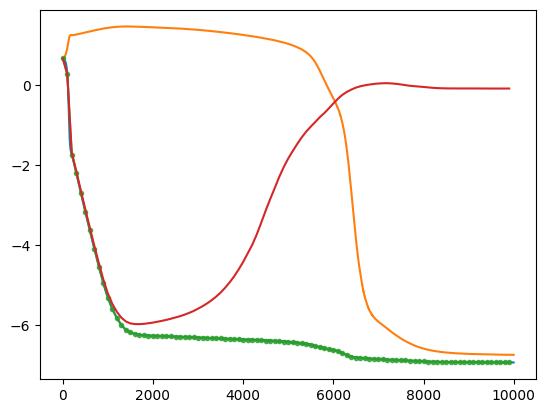

In [111]:
plt.plot(np.log10(save_dict['train_losses'][:10000])); 
plt.plot(np.log10(save_dict['test_losses'][:10000]))
plt.plot(ckpt_indices, np.log10(losses), '.-', alpha=0.8)
plt.plot(ckpt_indices, np.log10(losses_exl))

- Dare we try excluded accuracy? Did I already try that? 

In [95]:
def test_logits_accuracy(logits, bias_correction=False, original_logits=None, mode='all'):
    # Calculates cross entropy loss of logits representing a batch of all p^2 
    # possible inputs
    # Batch dimension is assumed to be first
    if logits.shape[1]==p*p:
        logits = logits.T
    if logits.shape==torch.Size([p*p, p+1]):
        logits = logits[:, :-1]
    logits = logits.reshape(p*p, p)
    if bias_correction:
        # Applies bias correction - we correct for any missing bias terms, 
        # independent of the input, by centering the new logits along the batch 
        # dimension, and then adding the average original logits across all inputs
        logits = einops.reduce(original_logits - logits, 'batch ... -> ...', 'mean') + logits
    if mode=='train':
        return ((logits[is_train].detach().argmax(1)==labels[is_train]).detach().cpu().sum()/len(labels[is_train]))
    elif mode=='test':
        return ((logits[is_test].detach().argmax(1)==labels[is_test]).detach().cpu().sum()/len(labels[is_test]))
    elif mode=='all':
        return ((logits.detach().argmax(1)==labels).detach().cpu().sum()/len(labels))

In [103]:
freq=4  #23 is intersting. 
losses=[]
losses_exl=[]

ckpt_indices=np.arange(0, 10000, 100)
for i in tqdm(ckpt_indices):
    save_dict_2=torch.load(root/run_name/(str(i)+'.pth'))
    model.load_state_dict(save_dict_2['model'])

    logits = model(all_data)[:, -1, :-1]

    losses.append(test_logits(logits, bias_correction=False, mode='train').item())

    # losses_exl.append(test_logits((logits - get_component_cos_xpy(logits, freq) - get_component_sin_xpy(logits, freq)), 
    #                            bias_correction=False, 
    #                            mode='train').item())
    logits_excluded=logits - get_component_cos_xpy(logits, freq) - get_component_sin_xpy(logits, freq)
    losses_exl.append(test_logits_accuracy(logits_excluded, 
                               bias_correction=False, 
                               mode='train').item())
    
losses=np.array(losses)
losses_exl=np.array(losses_exl)

100%|██████████████████████████████████████| 100/100 [00:04<00:00, 23.72it/s]


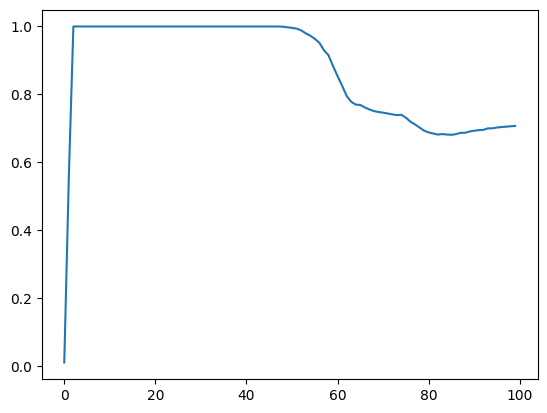

In [104]:
plt.plot(losses_exl)

- Hmm that might be kinda interesting!
- Eh wait no it should start high and then go low, right?
- Ok yeah I don't think excluded accuracy will work, that's ok exluded loss looks good for this model - that's a win!!!